<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/07_ensemble_learning_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensamble Learning: Gradient Boosting

__Disclaimer:__ This exercise is adopted from `"Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow (Third Edition)"` book written by `_Aurelien Geron_` publoshed by `_O'Reilly_`. I broke them down into smaller digestable snippets, made some modifications, and added some explanations so that I can undersatand them better. The porpuse of this notebook is just for me to understand the concept and have hands-on practice while reading the book material.

## Objective
Apply Gradient Boosting
 for ensamble learning

## Load Dataset

In [1]:
from sklearn.datasets import make_moons, load_iris, load_breast_cancer, load_wine, fetch_openml

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from graphviz import Source
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint, uniform

from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from IPython.display import Image
import time
import math


## Generate Dataset

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.1 * np.random.randn(100) # y = 3x^2 + Gaussian Noise

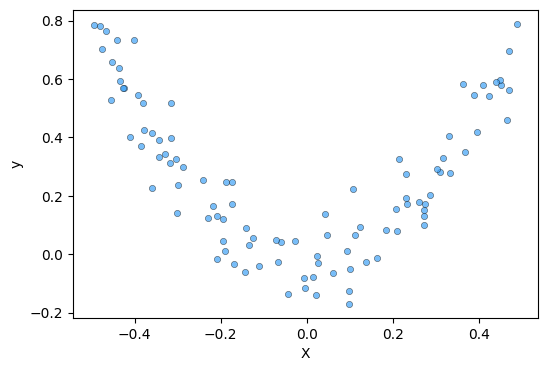

In [3]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=X[:, 0], y=y, marker='o', color='#3FA2F6', s=20, edgecolor='k', alpha=0.7)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

## Gradient Boosted Regression Trees (GBRT)

Below, I implement the gradient boosted regression trees by iterating over a `DecisionTreeRegressor` manually, then compare its prediction with the `GradientBoostingRegressor`. The hyperparameters are `n_extimators`, `max_depth`, and `learning_rate`. The`n_estimators` hyperparameter specifies how many times i want to fit a new `DecisionTreeClassifier` using the residuals of the previous predictor, i.e.,
$$y_i = y_{i-1} - \hat{y}_{i-1}$$
where $y_i$ and $y_{i-1}$ are the current and previous targets, and $\hat{y}_{i-1}$ is the prediction made by the latest fitted predictor.

In [4]:
def train_gradient_boosting(X, y, n_estimators, max_depth, learning_rate):
    trees = []
    X_train = X
    y_train = [y]

    for i in range(n_estimators):
        trees.append(DecisionTreeRegressor(max_depth=max_depth, random_state=42))
        trees[i].fit(X, y_train[i])
        y_train.append(y_train[i] - learning_rate * trees[i].predict(X))

    return trees, y_train


def predict_gradient_boosting(X, trees):
    y_pred = np.zeros(X.shape[0])
    for i in range(len(trees)):
        y_pred += trees[i].predict(X)

    return y_pred

In [5]:
n_estimators = 4
max_depth = 2
learning_rate = 1.0

In [6]:
trees, y_train = train_gradient_boosting(X, y, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
X_new = np.array([[-0.4], [0.], [0.5]])
y_pred = predict_gradient_boosting(X_new, trees)
print(y_pred)

[0.52067664 0.02657608 0.80125954]


In [7]:
gbrt = GradientBoostingRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
gbrt.fit(X, y)
print(gbrt.predict(X_new))

[0.52067664 0.02657608 0.80125954]


In [8]:
def plot_predictions(regressors, X, y, style, ax,
                     label=None, data_style="b.", data_label=None):

    x1 = np.linspace(X.min(), X.max(), 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    ax.plot(x1, y_pred, style, linewidth=2, label=label)
    ax.set_xlabel("X")
    ax.set_ylabel("y", rotation=0)

    if label or data_label:
        ax.legend(loc="upper center")

def generate_label(n):
    label = 'h(x) ='
    for i in range(n):
        label += f' h_{i//2+1} +'
    return label[:-2]

def generate_data_label(n):
    if n==0 or n==1:
        return 'Training set'
    elif n%2==1:
        return None
    else:
        label = 'Residuals: y -'
        for i in range(n//2):
            label += f' h{i+1}(x) -'
        return label[:-2]

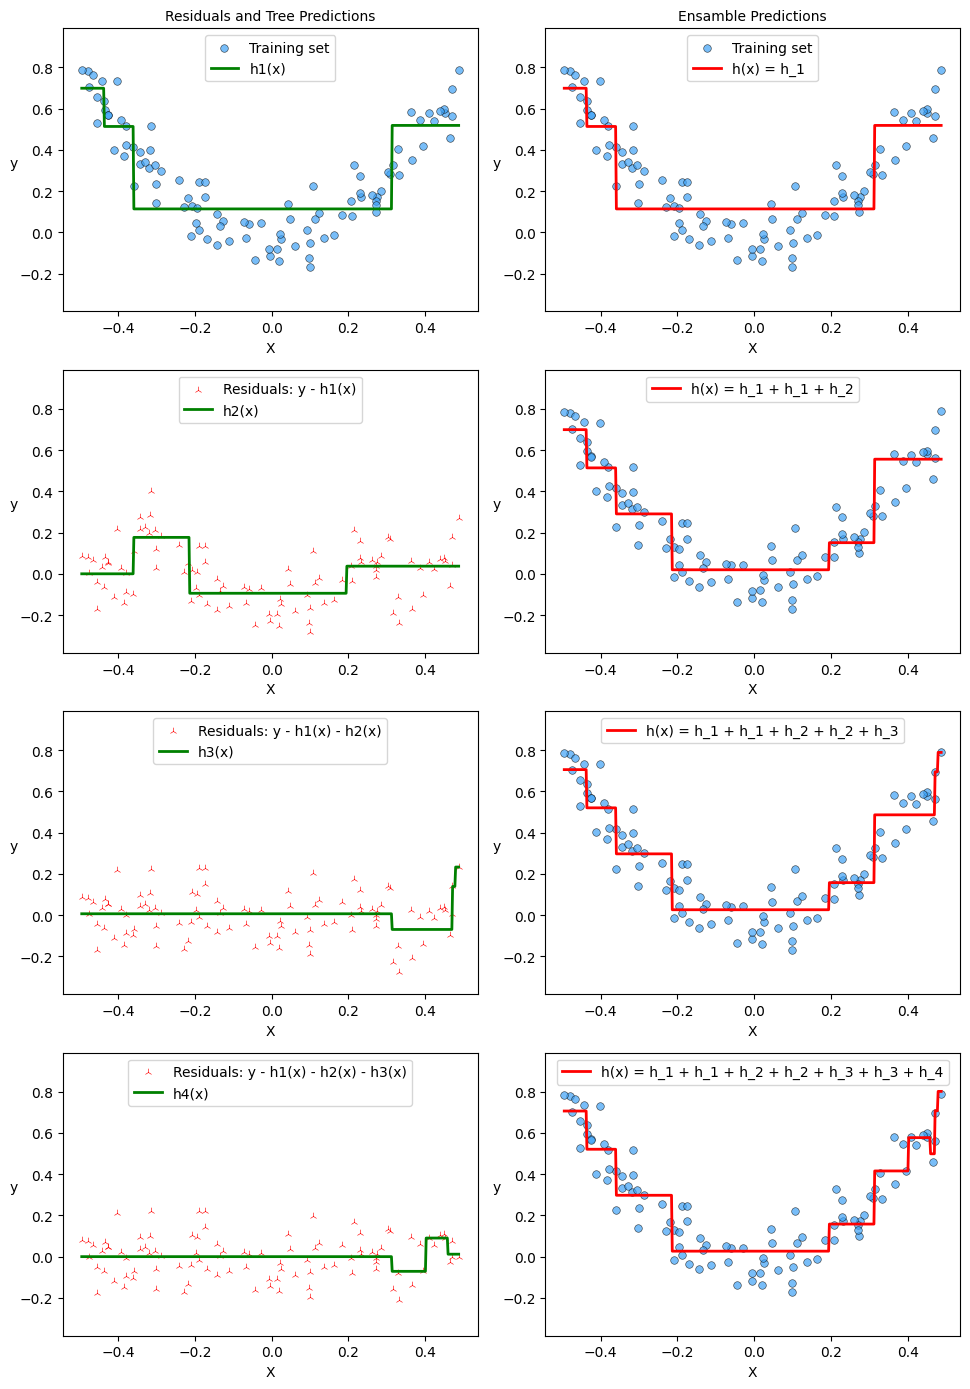

In [9]:
ymax =np.max(np.concatenate(y_train))
ymin = np.min(np.concatenate(y_train))

fig, axes = plt.subplots(nrows=n_estimators, ncols=2, figsize=(10,14))
axes = axes.flatten()

for i in range(len(axes)):
    if i==0:
        sns.scatterplot(x=X[:, 0], y=y, marker='o', color='#3FA2F6', s=30, edgecolor='k', alpha=0.7, ax=axes[i], label=generate_data_label(i))
        plot_predictions([trees[i//2]], X, y, style='g-', ax=axes[i], label=f'h{i//2+1}(x)')
    elif i%2==0:
        sns.scatterplot(x=X[:, 0], y=y_train[i//2], marker='2', color='red', s=30, alpha=1.0, ax=axes[i], label=generate_data_label(i))
        plot_predictions([trees[i//2]], X, y, style='g-', ax=axes[i], label=f'h{i//2+1}(x)')
    else:
        sns.scatterplot(x=X[:, 0], y=y, marker='o', color='#3FA2F6', s=30, edgecolor='k', alpha=0.7, ax=axes[i], label=generate_data_label(i))
        plot_predictions(trees[:i//2+1], X, y, style='r-', ax=axes[i], label=generate_label(i))

    axes[i].set_ylim(ymin-0.1, ymax+0.2)


axes[0].set_title('Residuals and Tree Predictions', fontsize=10)
axes[1].set_title('Ensamble Predictions', fontsize=10)
plt.tight_layout()
plt.show()

## Early Stopping
The _early stopping_ can be implemented by setting `n_iter_no_change` to an integer indicating the number of iterations required to achieve the maximum performance improvement. This improvement is set by `tol` hyperparameter (dafault=0.0001).<br><br>

By setting `n_iter_no_change` the `fit()` method automatically splits the training set into smaller training and validation set. The _training/validation_ ratio is 10% by default, but it can be adjusted using `validation_fraction` hyperparameter. Note that setting `n_iter_no_change` too low could lead to underfitting andf setting it too high may lead overfitting.<br><br>

 Let's perform this to find out how many predictors (e.g., estimators) is needed to achieve the default performace imporvement tolerance (i.e., `tol=0.0001`).

In [10]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    learning_rate = 1.,
    n_estimators=500,
    n_iter_no_change=10,
    validation_fraction=0.1,
    tol=0.0001,
    random_state=42)

gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [11]:
# Actual number of estimators
gbrt_best.n_estimators_

20

I used `n_estimator=3` for `gbrt`, but it seems to achieve a performance improvement tolerance of 0.0001, I need to use 20 estimators. Let's compare the performances of the two models.

In [12]:
# Generate test data set
np.random.seed(42)
X_test = np.random.rand(1000, 1) - 0.5
y_test = 3*X_test[:, 0]**2 + 0.10 * np.random.randn(1000)

In [13]:
print(f"GBRT with {gbrt.n_estimators} estimators: {gbrt.score(X_test, y_test):.3f}")
print(f"GBRT with {gbrt_best.n_estimators_} estimators: {gbrt_best.score(X_test, y_test):.3f}")

GBRT with 4 estimators: 0.766
GBRT with 20 estimators: 0.730


This indicates that the GBRT model with 20 estimators is not able to generalize quite well compared to the model with 4 estimators. Let's compare the MSE score improvement of the two models over the training set.

In [14]:
gbrt_staged_pred = np.array(list(gbrt.staged_predict(X)))
gbrt_best_staged_pred = np.array(list(gbrt_best.staged_predict(X)))

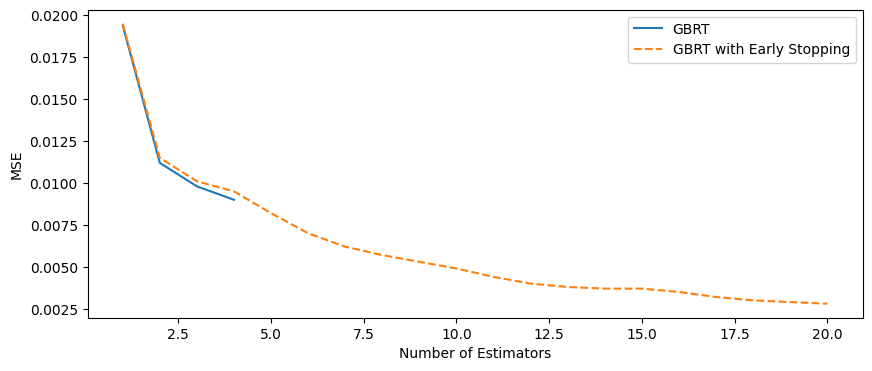

In [15]:
gbrt_staged_scores = []
for i in range(gbrt_staged_pred.shape[0]):
    gbrt_staged_scores.append(round(mean_squared_error(y, gbrt_staged_pred[i]), 4))

gbrt_best_staged_scores = []
for i in range(gbrt_best_staged_pred.shape[0]):
    gbrt_best_staged_scores.append(round(mean_squared_error(y, gbrt_best_staged_pred[i]), 4))


plt.figure(figsize=(10, 4))
plt.plot(range(1, gbrt.n_estimators_+1), gbrt_staged_scores, label='GBRT')
plt.plot(range(1, gbrt_best.n_estimators_+1), gbrt_best_staged_scores, '--', label='GBRT with Early Stopping')
plt.xlabel("Number of Estimators")
plt.ylabel("MSE")
plt.legend()
plt.show()


It is clear that there are quite an improvement in the preformance of the model with 20 estimators. However, as I checked earlier, it generalizes a bit poorly on the test set.

I want to specify a higher value for `n_iter_no_change` for the model and see how it changes the model generalization ability.

In [16]:
gbrt_best_1  = GradientBoostingRegressor(
    max_depth=2,
    learning_rate = 1.,
    n_estimators=500,
    n_iter_no_change=50,
    validation_fraction=0.1,
    tol=0.0001,
    random_state=42)

gbrt_best_1.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=500,
                          n_iter_no_change=50, random_state=42)

In [17]:
gbrt_best_1.n_estimators_

114

This model stopped at `n_estimators_=114` since I specified that I want no change in performace in the last 50 iterations with tolerance of 0.0001. Let's compare its score to the previous models.

In [18]:
print(f'GBRT with {gbrt_best_1.n_estimators_} estimators: {gbrt_best_1.score(X_test, y_test):.3f}')

GBRT with 114 estimators: 0.715


Here is how the three models performed on the test set:

* Score of the model with 4 estimators = 0.766
* Score of the model with 20 estimators = 0.730 (4.7% ↓)
* Score of the model with 114 estimators = 0.715 (6.7% ↓)

It is evident that increasing the `n_estimators_` will result in overfitting.

## Hyperparameter Optimization

Below, I will perform a gridsearch to find the optimized hyperparameters.

In [19]:
param_distributs = {
    'max_depth': randint(low=2, high=10),
    'learning_rate': uniform(loc=0.01, scale=1.01-0.01),
    'n_iter_no_change': randint(low=1, high=100)
}

rnd_search = RandomizedSearchCV(
    GradientBoostingRegressor(n_estimators=500, random_state=42),
    param_distributions=param_distributs,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error', # using neg. because RandomizedSearchCV maximizes the score, but I am trying to minimize the error
    random_state=42)

rnd_search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingRegressor(n_estimators=500,
                                                       random_state=42),
                   n_iter=50,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c4b502c2bf0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c4b4dc714b0>,
                                        'n_iter_no_change': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c4b4dda2320>},
                   random_state=42, scoring='neg_mean_squared_error')

In [20]:
rnd_search.best_params_

{'learning_rate': 0.025636406741193933, 'max_depth': 2, 'n_iter_no_change': 88}

Let's also perform a grid search around the parameters I obtained from random search.

In [21]:
param_grid = {
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.015, 0.020, 0.025, 0.030, 0.04, 0.05, 0.1, 0.5, 1.0],
    'n_iter_no_change': [10, 30, 50, 80, 100, 120]}

grid_search = GridSearchCV(
    GradientBoostingRegressor(n_estimators=500, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True)

grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(n_estimators=500,
                                                 random_state=42),
             param_grid={'learning_rate': [0.01, 0.015, 0.02, 0.025, 0.03, 0.04,
                                           0.05, 0.1, 0.5, 1.0],
                         'max_depth': [2, 3, 5],
                         'n_iter_no_change': [10, 30, 50, 80, 100, 120]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [22]:
grid_search.best_params_

{'learning_rate': 0.03, 'max_depth': 2, 'n_iter_no_change': 80}

In [23]:
print(f'Random search best score (MSE): {abs(rnd_search.best_score_):.4f}') # remember the search will retrun neg_mean_squared_error
print(f'Grid search best score (MSE): {abs(grid_search.best_score_):.4f}')

Random search best score (MSE): 0.0116
Grid search best score (MSE): 0.0116


Now, I am going to get the MSE score of the two models on the test set using their best parameters.

In [24]:
print(f'GBRT MSE using best params from Random Search with {rnd_search.best_estimator_.n_estimators_} estimators: {mean_squared_error(y_test, rnd_search.predict(X_test)):.4f}')
print(f'GBRT MSE using best params from Grid Search with {grid_search.best_estimator_.n_estimators_} estimators: {mean_squared_error(y_test, grid_search.predict(X_test)):.4f}')

GBRT MSE using best params from Random Search with 252 estimators: 0.0114
GBRT MSE using best params from Grid Search with 219 estimators: 0.0114


comparing the model scores on the training-validation set and test set shows they both generalized quite well.

In [25]:
print(f'GBRF MSE with {gbrt.n_estimators_} estimators: {mean_squared_error(y, gbrt.predict(X)):.4f}')
print(f'GBRT MSE with {gbrt_best.n_estimators_} estimators: {mean_squared_error(y, gbrt_best.predict(X)):.4f}')
print(f'GBRT MSE with {gbrt_best_1.n_estimators_} estimators: {mean_squared_error(y, gbrt_best_1.predict(X)):.4f}')

GBRF MSE with 4 estimators: 0.0090
GBRT MSE with 20 estimators: 0.0028
GBRT MSE with 114 estimators: 0.0013


## Summary

In [26]:

models = [gbrt, gbrt_best, gbrt_best_1, rnd_search, grid_search]
names = ['gbrt', 'gbrt_best', 'gbrt_best_1', 'rnd_search', 'grid_search']
columns = ['max_depth', 'learning_rate', 'n_iter_no_change', 'n_estimators', 'MSE (test)', 'Score (test)']

summary = pd.DataFrame(index=names, columns=columns)

In [27]:
for name, model in zip(names, models):
    try:
      summary.loc[name] = [
          int(model.get_params()['max_depth']),
          round(model.get_params()['learning_rate'], 3),
          model.get_params()['n_iter_no_change'],
          int(model.n_estimators_),
          round(mean_squared_error(y_test, model.predict(X_test)), 4),
          round(model.score(X_test, y_test), 4)
      ]
    except KeyError:
      summary.loc[name] = [
          int(model.best_estimator_.get_params()['max_depth']),
          round(model.best_estimator_.get_params()['learning_rate'], 3),
          int(model.best_estimator_.n_iter_no_change),
          int(model.best_estimator_.n_estimators_),
          round(mean_squared_error(y_test, model.predict(X_test)), 4),
          round(model.best_estimator_.score(X_test, y_test), 4)
      ]


In [28]:
summary

,max_depth,learning_rate,n_iter_no_change,n_estimators,MSE (test),Score (test)
gbrt,2,1.0,None,4,0.0137,0.7665
gbrt_best,2,1.0,10,20,0.0158,0.7301
gbrt_best_1,2,1.0,50,114,0.0167,0.7148
rnd_search,2,0.026,88,252,0.0114,0.8053
grid_search,2,0.03,80,219,0.0114,0.8051


Both models obtained resulted from the search algorithms (`GridSearchCV` and `RandomizedSearchCV`) utilizes comparable hyperparameters and both achieved comparable MSE and accuracy scores.